Starting Portfolio Value: 1000.00
2019-01-02, Close, 1.1354
2019-01-02, Close, 1.1356
2019-01-02, BUY CREATE, 1.14
2019-01-02, Close, 1.1335
2019-01-02, Close, 1.1328
2019-01-02, Close, 1.1343
2019-01-02, Close, 1.1345
2019-01-02, Close, 1.1343
2019-01-02, Close, 1.1336
2019-01-02, Close, 1.1312
2019-01-03, BUY EXECUTED, Price: 1.13, Cost: 113.12, Comm 0.00
2019-01-03, Close, 1.1340
2019-01-03, Close, 1.1348
2019-01-03, Close, 1.1358
2019-01-03, Close, 1.1365
2019-01-03, Close, 1.1367
2019-01-03, Close, 1.1361
2019-01-03, Close, 1.1372
2019-01-03, Close, 1.1370
2019-01-03, Close, 1.1380
2019-01-03, Close, 1.1376
2019-01-03, Close, 1.1368
2019-01-03, SELL CREATE, 1.14
2019-01-03, Close, 1.1341
2019-01-03, Close, 1.1343
2019-01-03, Close, 1.1365
2019-01-03, Close, 1.1364
2019-01-03, Close, 1.1393
2019-01-03, Close, 1.1398
2019-01-03, Close, 1.1399
2019-01-03, Close, 1.1401
2019-01-03, Close, 1.1391
2019-01-03, Close, 1.1398
2019-01-03, Close, 1.1392
2019-01-03, Close, 1.1393
2019-01-03, 

<IPython.core.display.Javascript object>


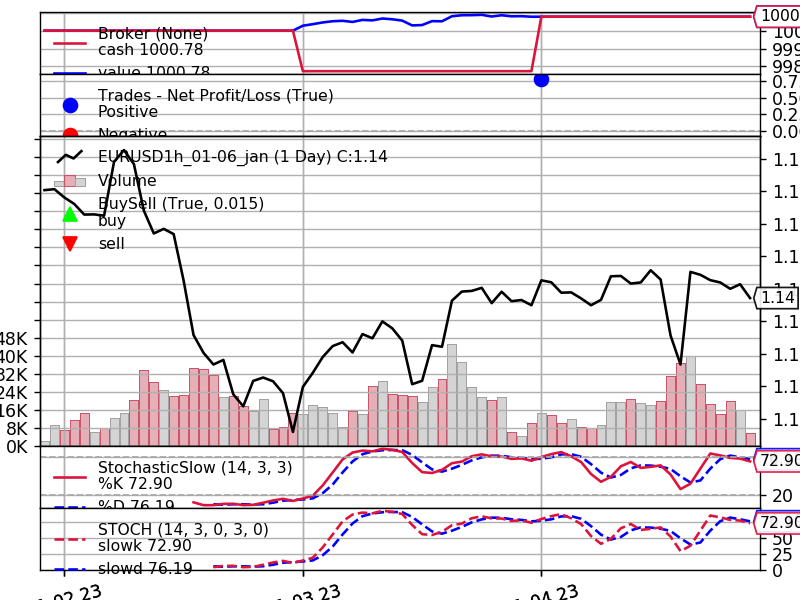

In [1]:

from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt
import backtrader.feeds as btfeed


# Create a Stratey
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        
         # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
        # Add a Stochastic indicator
        self.stoch = bt.indicators.StochasticSlow(self.datas[0])
        
        # Indicators for the plotting show
        self.stoc = bt.talib.STOCH(self.data.high, self.data.low, self.data.close,
                                   fastk_period=14, slowk_period=3, slowd_period=3)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    
    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.4f' % self.dataclose[0])
        
#         print (self.stoch.lines.percK[0])
#         print (self.stoch.lines.percD[0])
        
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.stoch.lines.percK[-1] < self.stoch.lines.percD[-1] and self.stoch.lines.percK[0] > self.stoch.lines.percD[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.stoch.lines.percK[-1] > self.stoch.lines.percD[-1] and self.stoch.lines.percK[0] < self.stoch.lines.percD[0]:

                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()
                


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    datapath = os.path.join(modpath, 'backtrader\datas\EURUSD1h_01-06_jan.txt')

    # Create a Data Feed
    data = btfeed.GenericCSVData(
        dataname=datapath,

        fromdate=datetime.datetime(2019, 1, 1),
        todate=datetime.datetime(2019, 1, 6),

        nullvalue=0.0,

        dtformat=('%Y%m%d'),
        tmformat=('%H:%M:%S'),

        datetime=0,
        timestamp=1,
        open=2,
        high=3,
        low=4,
        close=5,
        volume=6
    )

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(1000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)

    # Set the commission
    cerebro.broker.setcommission(leverage=50)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Plot the result
    cerebro.plot()